# Customer Behaviour
Look at customer behaviour 

In [2]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "6g")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

22/10/05 16:19:47 WARN Utils: Your hostname, James-N580VD-DM229T resolves to a loopback address: 127.0.1.1; using 172.22.110.66 instead (on interface eth0)
22/10/05 16:19:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/05 16:19:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/05 16:19:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [45]:
dataset = spark.read.parquet('../data/curated/full_dataset/')

First lets look at time between purchases

In [54]:
sub = dataset.select(['user_id', 'dollar_value', 'order_datetime']).orderBy('order_datetime')

In [59]:
from pyspark.sql.window import Window
windowSpec = Window.partitionBy("user_id").orderBy("order_datetime")
sub = sub.withColumn("lag",F.lag("order_datetime",1).over(windowSpec))
sub = sub.withColumn('time_between', F.datediff(F.col('order_datetime'), 'lag'))

In [76]:
sub_2 = dataset.select(['user_id', 'dollar_value', 'order_datetime']).orderBy('order_datetime')

In [77]:
sub_2 = sub_2.groupBy(['user_id', 'order_datetime']).agg(F.count('dollar_value').alias('No_of_transactions'), F.round(F.sum('dollar_value'), 2).alias('Total_spent_on_day'))

<AxesSubplot:xlabel='Total_spent_on_day', ylabel='Count'>

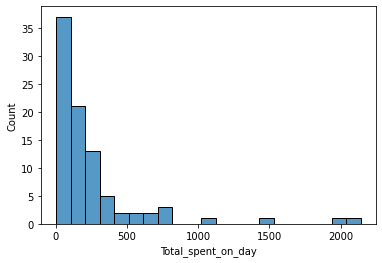

In [78]:
import seaborn as sns
sns.histplot(x='Total_spent_on_day', data=sub_2.where(F.col('user_id') == 7).toPandas())

<AxesSubplot:xlabel='dollar_value', ylabel='Count'>

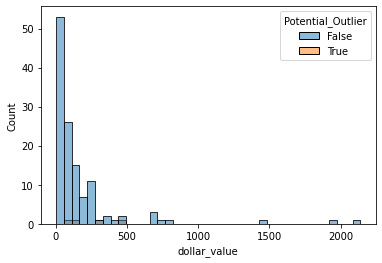

In [82]:
sns.histplot(x='dollar_value',hue='Potential_Outlier', data=dataset.where(F.col('user_id') == 7).toPandas())

In [83]:
bh = dataset.where((F.col('user_id') == 7) & (F.col('Potential_Outlier') == True))